In [32]:
import shbeamforming as shb
import numpy as np
import scipy.special as sp
import matplotlib.pyplot as plt
import soundfile as sf
from scipy.interpolate import griddata
import seaborn as sns
import resampy

# spherical peak finding
from dipy.core.sphere import Sphere
from dipy.direction import peak_directions

%matplotlib notebook

In [34]:
# import audio file
audio, fs = sf.read('audio/QS_Ambi_Cut.wav')
# audio, fs = sf.read('audio/noise_ambi.wav')
# audio, fs = sf.read('audio/PZ_Ambi_cut.wav')

# trim to length
audio = audio[fs*0:fs*10,:].T

# resample
fs_new = 16000
p_nm_t = resampy.resample(audio, fs, fs_new)
fs = fs_new

# set fft length and calculate num. frames
N_fft = 256
N_frames = len(p_nm_t.T)//N_fft

In [7]:
# set spherical harmonics order
N_sh = 4

# set sampling directions
points = shb.spherical_sampling.fibonacci(600)
theta_look, phi_look = points[:,0], points[:,1]

# set up sphere object for peak finding
sph = Sphere(theta=phi_look, phi=theta_look)

# beampattern parameters
c1, c2 = shb.cropac_beams(N_sh, theta_look, phi_look)

# remove channels for SH orders > N_sh
p_nm_t = p_nm_t[:(N_sh+1)**2, :]

<IPython.core.display.Javascript object>


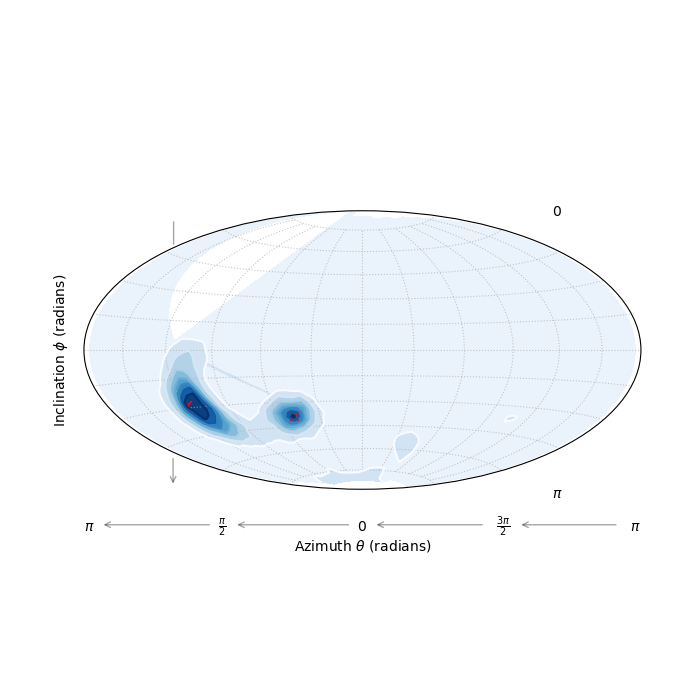

In [48]:
# plotting (& peak finding)

# set up output arrays for DOAs
xovertime = np.zeros((N_frames,20))
yovertime = np.zeros((N_frames,20))

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='hammer')
plt.tight_layout(pad=4)

# ax.set_figheight(15)
# ax.set_figwidth(15)
# ax2.set_figheight(15)
# ax2.set_figwidth(15)


for i in range(N_frames):
    
    ax.clear()
    
    frame = p_nm_t[:,N_fft*i:N_fft*(i+1)] # trim to frame
    p_nm_k = np.fft.fft(frame)[:,:N_fft//2]
    
    cpc1 = c1 @ p_nm_k
    cpc2 = c2 @ p_nm_k    

    # frequency band weighting (constant here)
    beta_zk = np.array([1]*(N_fft//2))

    # calculate cross-pattern coherence and sum across frequency bands
    cropac = shb.rectify(np.real(np.conj(cpc1)*cpc2)) @ beta_zk

    # multiplication of rotated versions for sidelobe cancellation
    cropac = np.prod(cropac,0).T

    
    # Plotting the results
    x = points[:,0]; y = points[:,1]; z = cropac
    N = int(np.ceil(np.sqrt(6000)))
    xi, yi = np.meshgrid(np.linspace(0, 2*np.pi, N),
                           np.linspace(0, np.pi, N))
    # interpolate fibonacci sample points to grid
    zi = griddata((x, y), z, (xi, yi))

    # peak finding in spherical data
    _,_,peaks = peak_directions(cropac, sph, min_separation_angle=5)
    
    # save peaks to arrays
    xdirs = points[peaks][:,0]
    ydirs = points[peaks][:,1]
    xovertime[i,0] = i
    yovertime[i,0] = i
    xovertime[i,1:len(xdirs)+1] += xdirs
    yovertime[i,1:len(xdirs)+1] += ydirs
    
    
#     ax.contour(np.degrees(xi), np.degrees(yi), zi, 20, linewidths=0.5, colors='Black')
#     ax.contourf(np.degrees(xi), np.degrees(yi), zi, 20, cmap='Blues')
    ax.contour((xi-np.pi),-(yi-np.pi/2),zi,cmap='Blues')#, 10, linewidths=.5, colors='Black')
    ax.contourf((xi-np.pi),-(yi-np.pi/2),zi,cmap='Blues')#, 10, cmap='Blues')
    
#     ax.scatter(-(x-np.pi), -(y-np.pi/2), c=z, cmap='Blues', s=4 )
    ax.scatter((points[peaks,0]-np.pi), -(points[peaks,1]-np.pi/2), color='red', marker='x')
    
    ax.grid(True, alpha=.7, linestyle=':')

    # custom x-axis
    ax.text(.49, -.15, '0', ha='left', transform=ax.transAxes)
    ax.text(.24, -.15, r'$\frac{\pi}{2}$', ha='left', transform=ax.transAxes)
    ax.text(0, -.15, r"$\pi$", ha='left', transform=ax.transAxes)
    ax.text(.74, -.15, r"$\frac{3\pi}{2}$", ha='left', transform=ax.transAxes)
    ax.text(.98, -.15, r"$\pi$", ha='left', transform=ax.transAxes)
    
    ax.annotate('', xy=(.96, -.1275), xycoords='axes fraction', xytext=(.78, -.1275), 
            arrowprops=dict(arrowstyle="<-", alpha=.35))
    ax.annotate('', xy=(.72, -.1275), xycoords='axes fraction', xytext=(.52, -.1275), 
            arrowprops=dict(arrowstyle="<-", alpha=.35))
    ax.annotate('', xy=(.48, -.1275), xycoords='axes fraction', xytext=(.27, -.1275), 
            arrowprops=dict(arrowstyle="<-", alpha=.35))
    ax.annotate('', xy=(.23, -.1275), xycoords='axes fraction', xytext=(.03, -.1275), 
            arrowprops=dict(arrowstyle="<-", alpha=.35))
    
    
    # custom y-axis
    ax.text(.15, .98, '0', ha='left', transform=ax.transAxes)
    ax.text(.15, -.03, r"$\pi$", ha='left', transform=ax.transAxes)
    
    ax.annotate('', xy=(.16, .12), xycoords='axes fraction', xytext=(.16, .01), 
            arrowprops=dict(arrowstyle="<-", alpha=.35))
    ax.annotate('', xy=(.161, .97), xycoords='axes fraction', xytext=(.161, .87), 
            arrowprops=dict(arrowstyle="-", alpha=.35))     


    ax.set_xticklabels([])
    ax.set_yticklabels([])
                      
    ax2.set_xticklabels([])
    ax2.set_yticklabels([])


    ax.set_xlabel(r'Azimuth $\theta$ (radians)', labelpad=35)
    ax.set_ylabel(r'Inclination $\phi$ (radians)')

    fig.canvas.draw()

# plt.savefig('fib_samp_600_tones.pdf')

In [38]:
peaks

array([283, 253], dtype=int64)

In [47]:
points[peaks][:,0]

array([5.67760447, 2.27827768])

In [41]:
np.array([xi[peak[0], peak[1]] for peak in peaks])

IndexError: invalid index to scalar variable.

In [42]:
peaks

array([283, 253], dtype=int64)

In [44]:
for peak in peaks:
    print(peak)

283
253


<IPython.core.display.Javascript object>


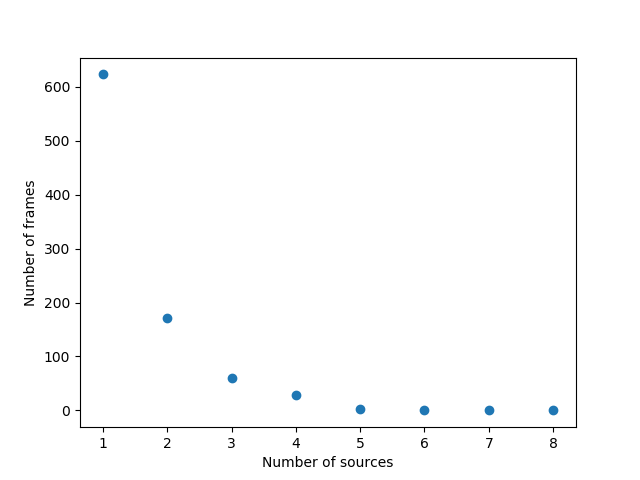

Text(0,0.5,'Number of frames')

In [61]:
fig2 = plt.figure()
plt.scatter(np.arange(1,9),np.count_nonzero(xovertime[:,1:9], axis=0))
plt.xlabel('Number of sources')
plt.ylabel('Number of frames')
# plt.savefig('qs_sources_per_frame.pdf')

In [62]:
# np.savetxt('qs_cropac_x.dat', xovertime)
# np.savetxt('qs_cropac_y.dat', yovertime)

In [63]:
N_frames

625